<a href="https://colab.research.google.com/github/MistyGrover03/Product_Suggestion_Based_Upon_Image_Uploaded/blob/main/Product.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install lancedb open_clip_torch -Uq


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.6/45.6 MB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.6/229.6 kB 9.3 MB/s eta 0:00:00


In [ ]:
from pathlib import Path
import pandas as pd
from PIL import Image as PILImage, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import os, shutil
import pyarrow as pa
import lancedb
from pydantic import BaseModel
from lancedb.embeddings import EmbeddingFunctionRegistry
from lancedb.pydantic import LanceModel, Vector
from IPython.display import Image as IPyImage, display
import kagglehub

In [ ]:
dataset_path = Path(kagglehub.dataset_download("hiteshsuthar101/myntra-fashion-product-dataset"))
IMAGE_DATA_PATH = dataset_path / "Images/Images"
CSV_PATH = dataset_path / "Fashion Dataset.csv"

print("Dataset CSV exists:", CSV_PATH.exists())
print("Number of images found:", len(list(IMAGE_DATA_PATH.glob("*.jpg"))))


100%|██████████| 2.90G/2.90G [00:35<00:00, 88.0MB/s]

Extracting files...


Dataset CSV exists: True
Number of images found: 14481


In [ ]:
df = pd.read_csv(CSV_PATH)
df.columns = df.columns.str.strip()

In [ ]:
# Keep only rows with valid price and avg_rating
df = df.dropna(subset=['price', 'avg_rating'])
df['price'] = pd.to_numeric(df['price'], errors='coerce')
df['avg_rating'] = pd.to_numeric(df['avg_rating'], errors='coerce')
df = df.dropna(subset=['price', 'avg_rating'])
df = df.reset_index(drop=True)

# Map CSV rows to actual images by row order
available_images = sorted(list(IMAGE_DATA_PATH.glob("*.jpg")), key=lambda x: int(x.stem))
num_images = min(len(df), len(available_images))
df = df.iloc[:num_images]
df['file_path'] = [str(available_images[i]) for i in range(num_images)]

print("Total rows after mapping to actual images:", len(df))
print(df[['file_path','price','avg_rating']].head())

Total rows after mapping to actual images: 6581
                                           file_path   price  avg_rating
0  /root/.cache/kagglehub/datasets/hiteshsuthar10...  5099.0    4.418399
1  /root/.cache/kagglehub/datasets/hiteshsuthar10...  5899.0    4.119334
2  /root/.cache/kagglehub/datasets/hiteshsuthar10...  4899.0    4.161530
3  /root/.cache/kagglehub/datasets/hiteshsuthar10...  3699.0    4.088986
4  /root/.cache/kagglehub/datasets/hiteshsuthar10...  1350.0    3.978377


In [ ]:
def select_embeddings_model(model_name: str = 'open-clip'):
    registry = EmbeddingFunctionRegistry.get_instance()
    model = registry.get(model_name).create()
    return model

model = select_embeddings_model()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


open_clip_model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

In [ ]:
class Myntra(LanceModel):
    vector: Vector(model.ndims()) = model.VectorField()
    file_path: str = model.SourceField()
    price: float
    rating: float

In [ ]:
schema_map = {'myntra': Myntra}

In [ ]:
class CreateLanceDBTable(BaseModel):
    database: str
    table_name: str
    table_schema: type   # Corrected: 'type' instead of 'any'
    mode: str

def create_lancedb_table(config: CreateLanceDBTable, data: pd.DataFrame):
    db = lancedb.connect(config.database)

    if config.table_name in db:
        print(f"{config.table_name} exists. Overwriting...")

    # Create table with the given schema
    table = db.create_table(config.table_name, schema=config.table_schema, mode=config.mode)

    # Rename avg_rating → rating to match schema
    table.add(
        pa.Table.from_pandas(
            data[['file_path','price','avg_rating']].rename(columns={'avg_rating':'rating'})
        ),
        mode="append"
    )

    print("✅ LanceDB table created.")


In [ ]:
def display_results(df, output_dir, label):
    print(f"\n📌 {label} results — {len(df)} found")
    if output_dir.exists():
        shutil.rmtree(output_dir)
    os.makedirs(output_dir)
    for idx, item in df.iterrows():
        img = PILImage.open(item.file_path)
        img_path = output_dir / f"{label}_{idx}_p{item.price}_r{item.rating}.jpg"
        img.save(img_path, 'JPEG')
        print(f"{label} Result: ₹{item.price}, ⭐{item.rating}, {item.file_path}")
    for img_file in sorted(output_dir.glob('*.jpg')):
        display(IPyImage(filename=img_file))


In [ ]:
class LanceDBSearchQuery(BaseModel):
    database: str
    table_name: str
    query: Path
    limit: int
    output_path: Path
    min_rating: float
    max_budget: float

def run_vector_db_search(query: LanceDBSearchQuery):
    db = lancedb.connect(query.database)
    table = db.open_table(query.table_name)

    search_img = PILImage.open(str(query.query))

    # 1️⃣ Search before any filters
    raw_results = table.search(search_img).limit(query.limit).to_pandas()

    # 2️⃣ Search after budget & rating filter
    filtered_results = table.search(search_img).where(
        f"price <= {query.max_budget} AND rating >= {query.min_rating}"
    ).limit(query.limit).to_pandas()

    display_results(raw_results, query.output_path / "before_filter", "BeforeFilter")
    display_results(filtered_results, query.output_path / "after_filter", "AfterFilter")

In [ ]:
create_lancedb_table(
    CreateLanceDBTable(
        database="/kaggle/working/lancedb",
        table_name="myntra",
        table_schema=Myntra,
        mode='overwrite'
    ),
    df
)


100%|██████████| 53/53 [00:15<00:00,  3.42it/s]


✅ LanceDB table created.



📌 BeforeFilter results — 5 found
BeforeFilter Result: ₹2199.0, ⭐5.0, /root/.cache/kagglehub/datasets/hiteshsuthar101/myntra-fashion-product-dataset/versions/1/Images/Images/3931.jpg
BeforeFilter Result: ₹2950.0, ⭐3.979591836734694, /root/.cache/kagglehub/datasets/hiteshsuthar101/myntra-fashion-product-dataset/versions/1/Images/Images/3185.jpg
BeforeFilter Result: ₹2499.0, ⭐4.333333333333333, /root/.cache/kagglehub/datasets/hiteshsuthar101/myntra-fashion-product-dataset/versions/1/Images/Images/3817.jpg
BeforeFilter Result: ₹6770.0, ⭐4.727272727272728, /root/.cache/kagglehub/datasets/hiteshsuthar101/myntra-fashion-product-dataset/versions/1/Images/Images/4517.jpg
BeforeFilter Result: ₹2998.0, ⭐4.055555555555555, /root/.cache/kagglehub/datasets/hiteshsuthar101/myntra-fashion-product-dataset/versions/1/Images/Images/4356.jpg


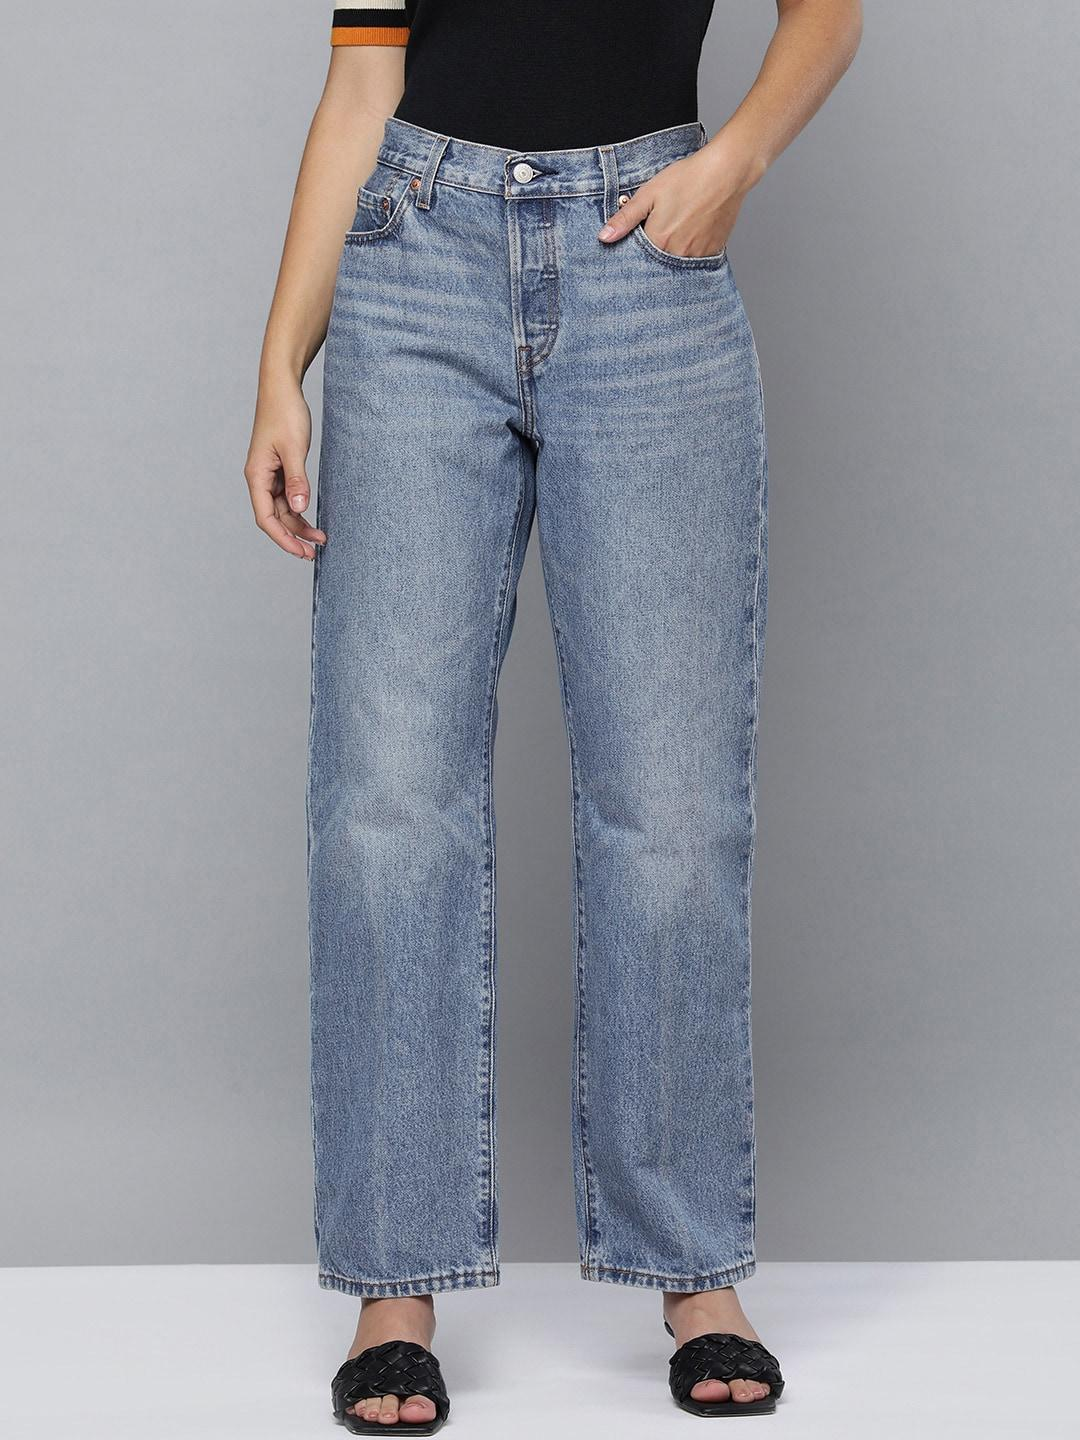

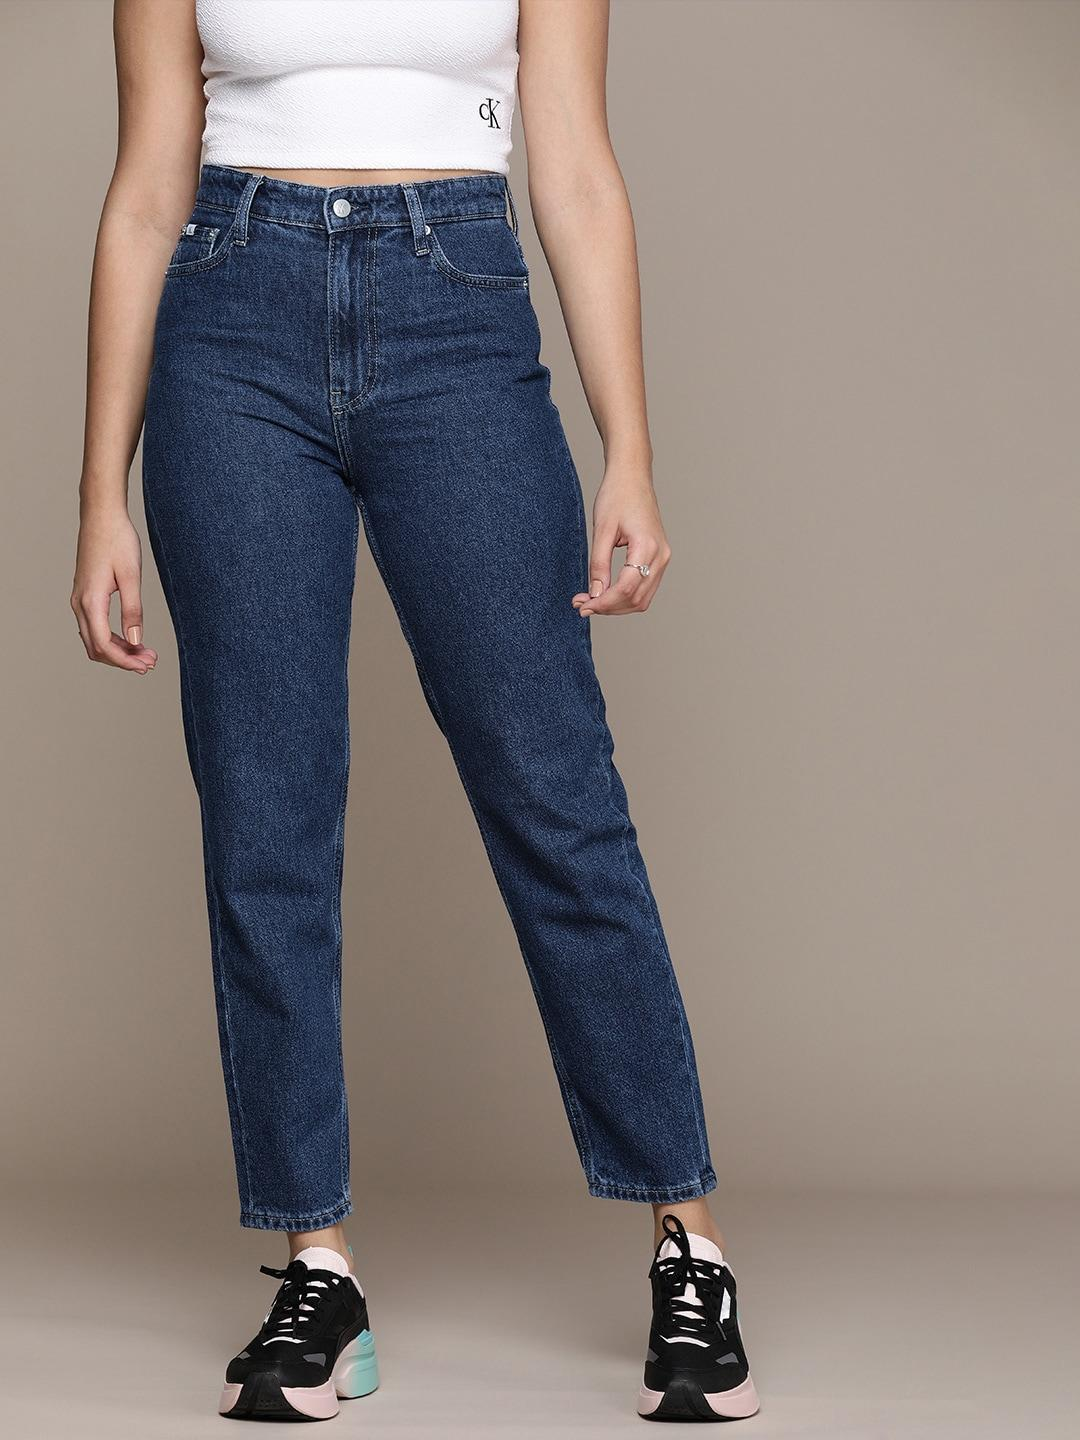

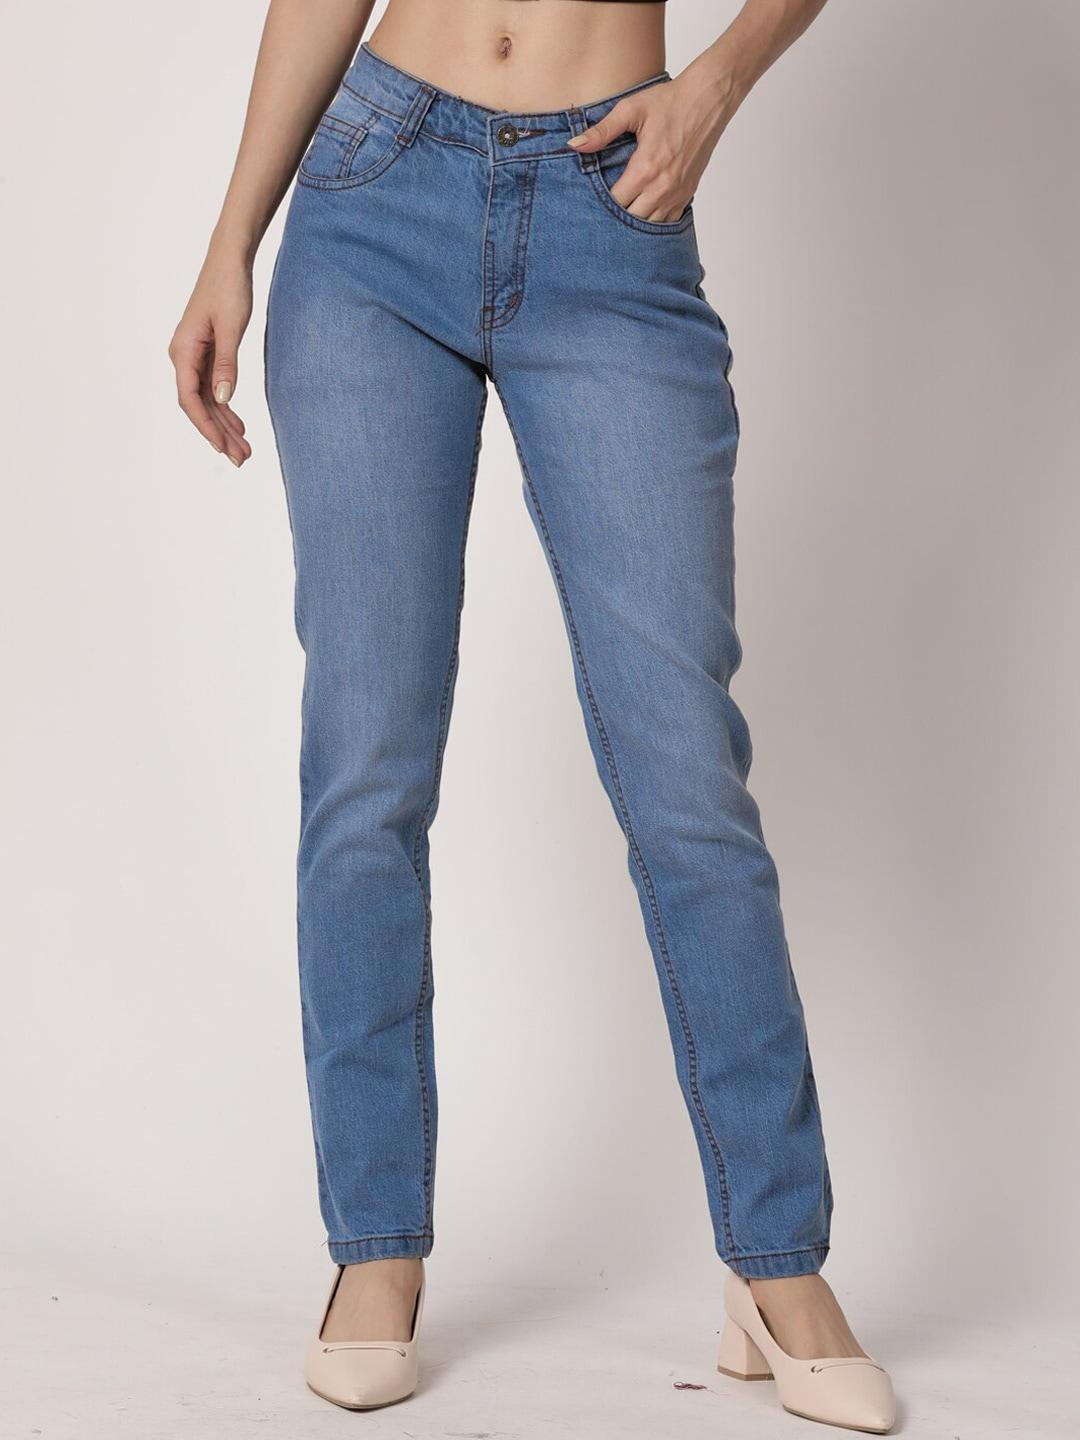

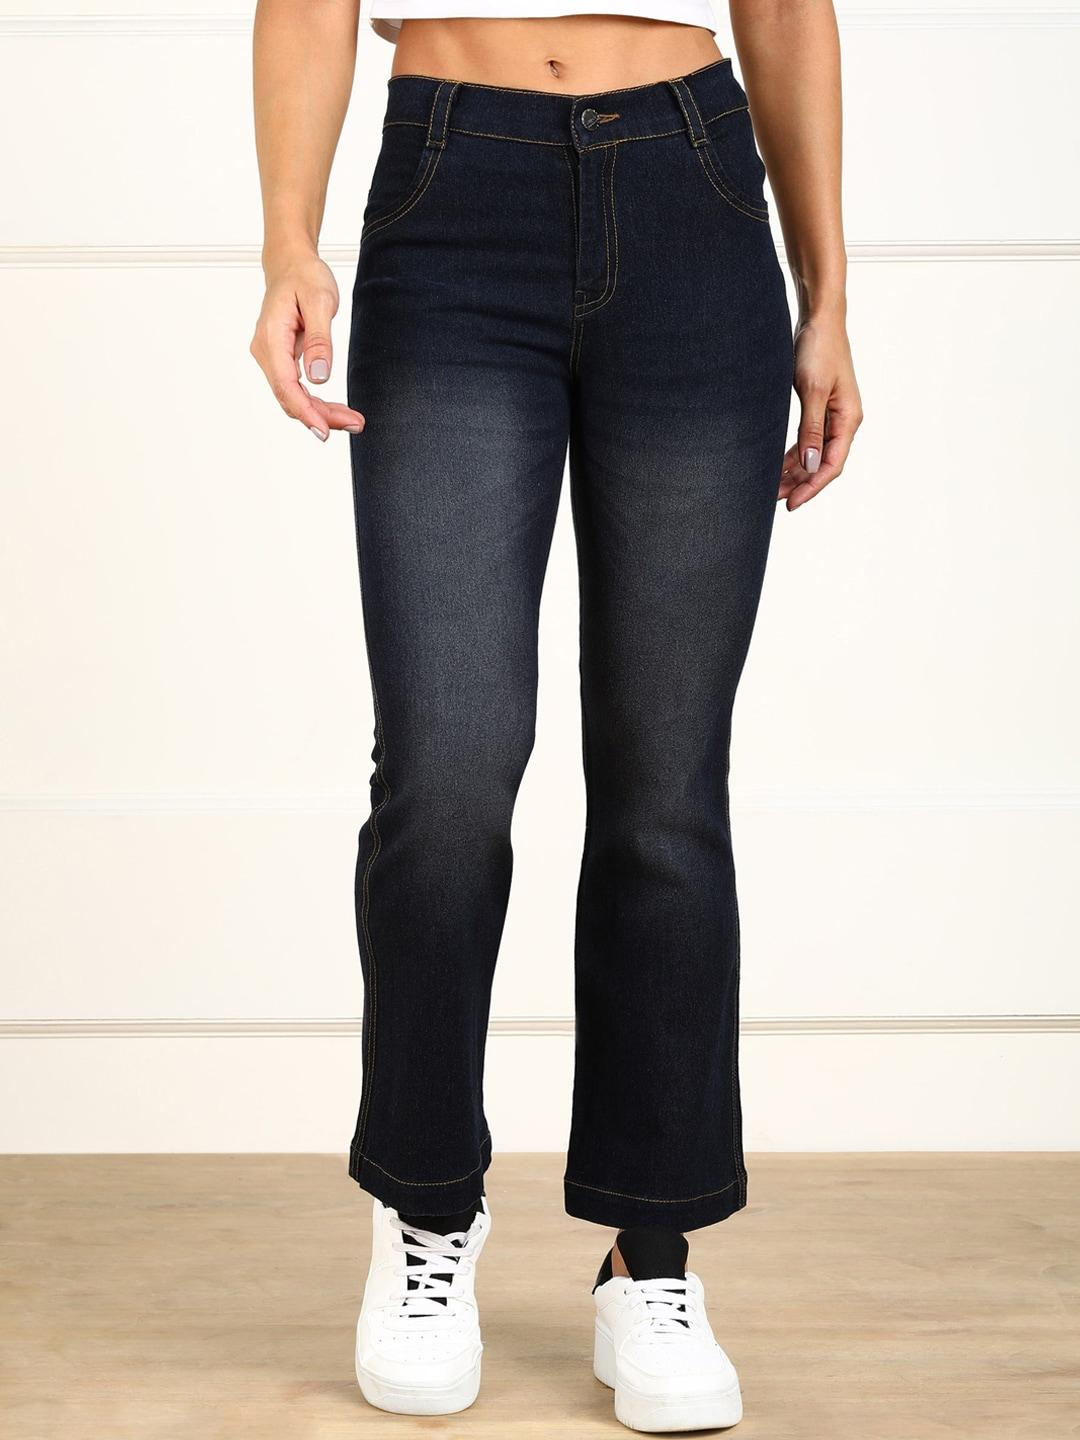

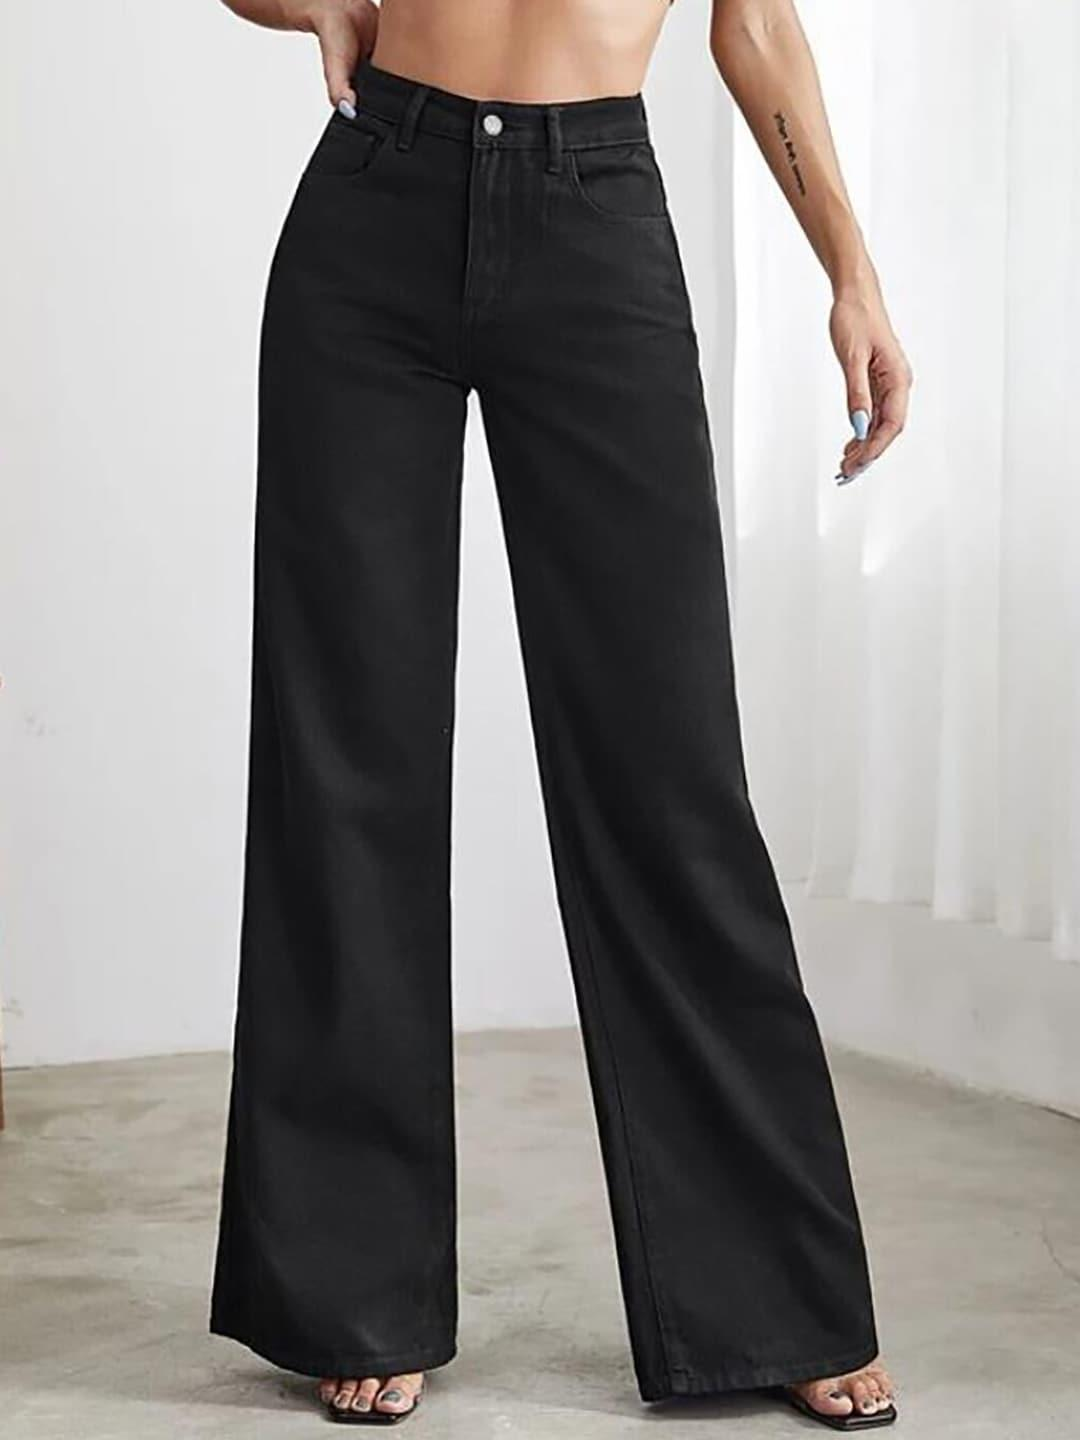


📌 AfterFilter results — 5 found
AfterFilter Result: ₹1999.0, ⭐4.333333333333333, /root/.cache/kagglehub/datasets/hiteshsuthar101/myntra-fashion-product-dataset/versions/1/Images/Images/3030.jpg
AfterFilter Result: ₹1499.0, ⭐4.285714285714286, /root/.cache/kagglehub/datasets/hiteshsuthar101/myntra-fashion-product-dataset/versions/1/Images/Images/1950.jpg
AfterFilter Result: ₹1599.0, ⭐4.75, /root/.cache/kagglehub/datasets/hiteshsuthar101/myntra-fashion-product-dataset/versions/1/Images/Images/5147.jpg
AfterFilter Result: ₹1499.0, ⭐4.331989247311828, /root/.cache/kagglehub/datasets/hiteshsuthar101/myntra-fashion-product-dataset/versions/1/Images/Images/3806.jpg
AfterFilter Result: ₹1770.0, ⭐4.058199246833277, /root/.cache/kagglehub/datasets/hiteshsuthar101/myntra-fashion-product-dataset/versions/1/Images/Images/786.jpg


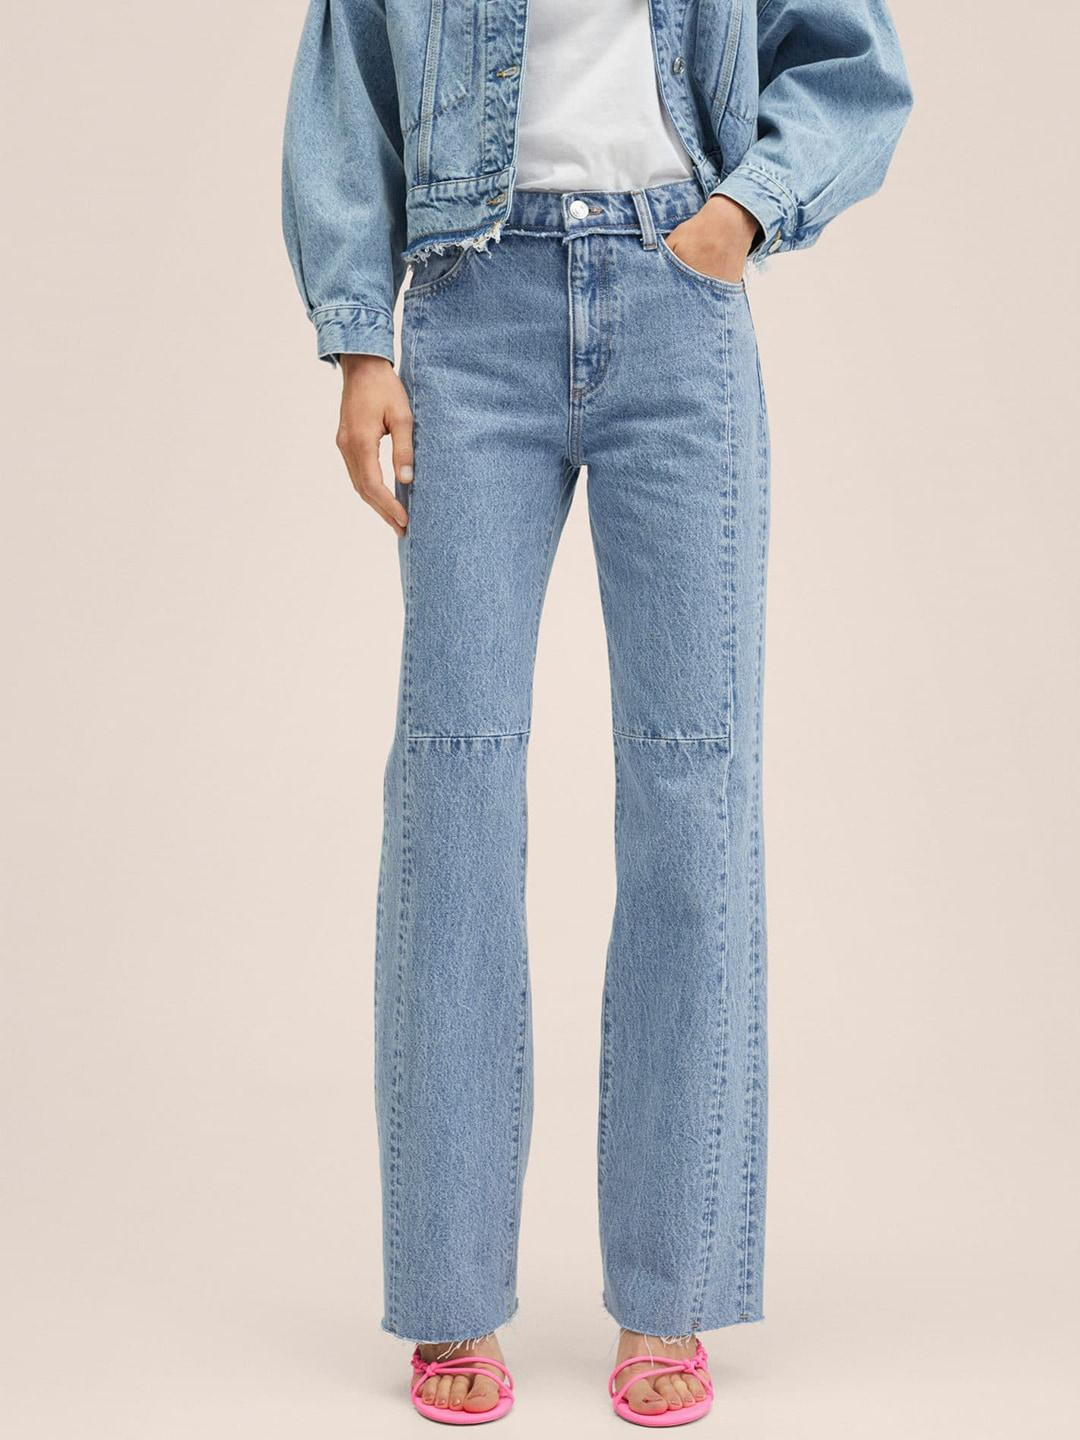

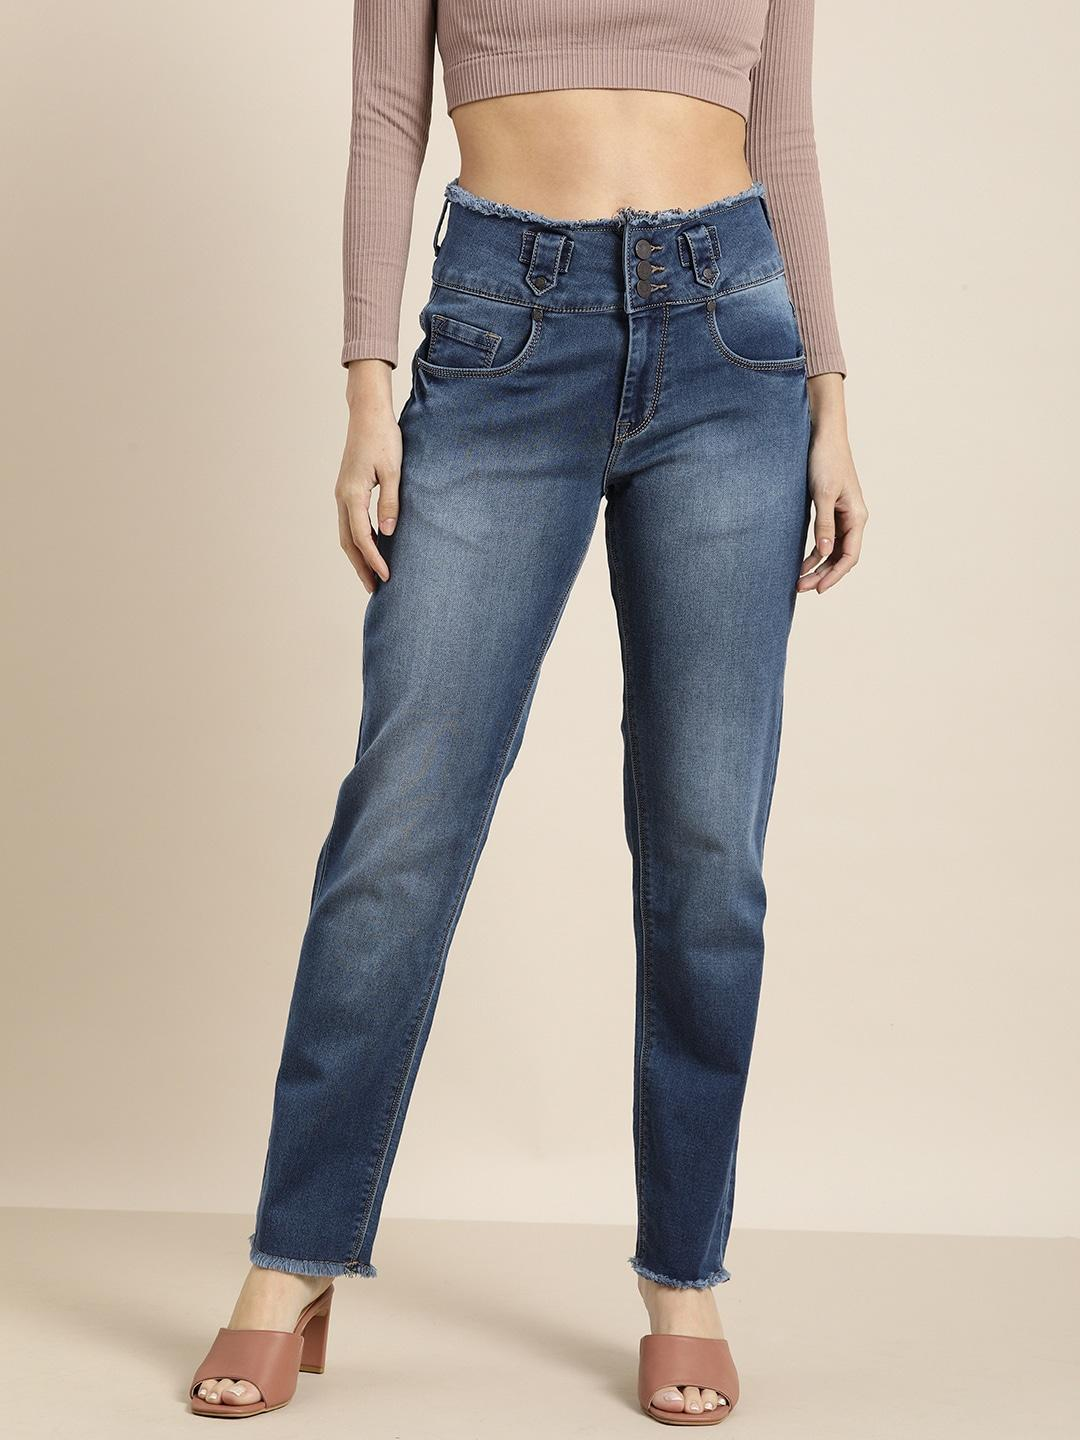

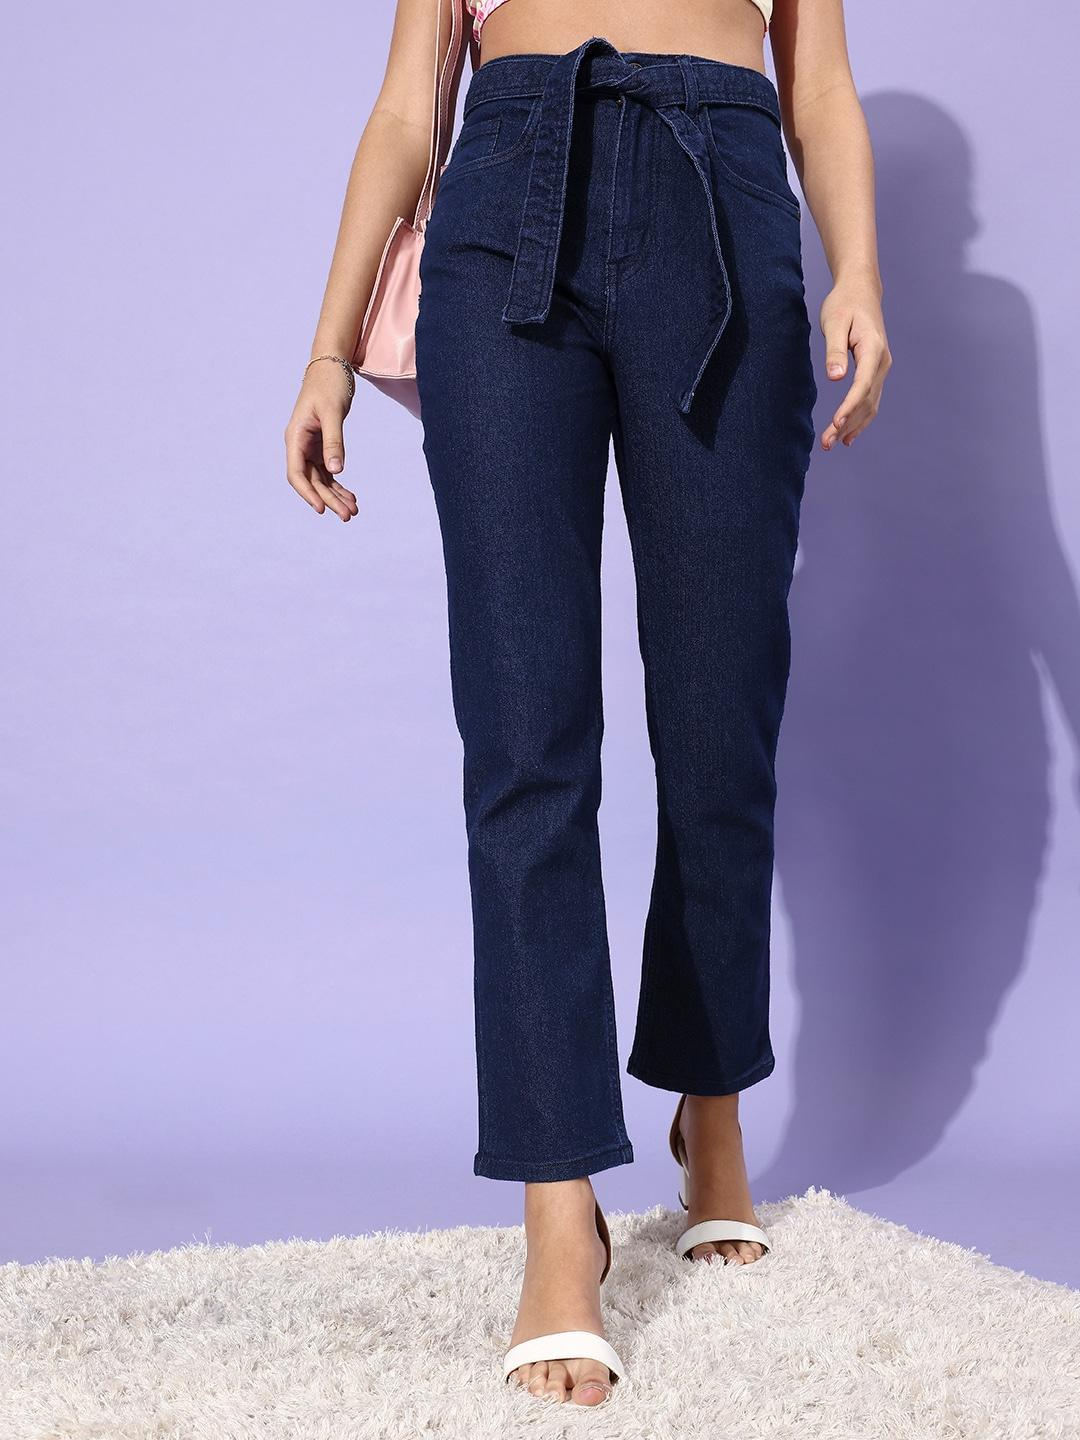

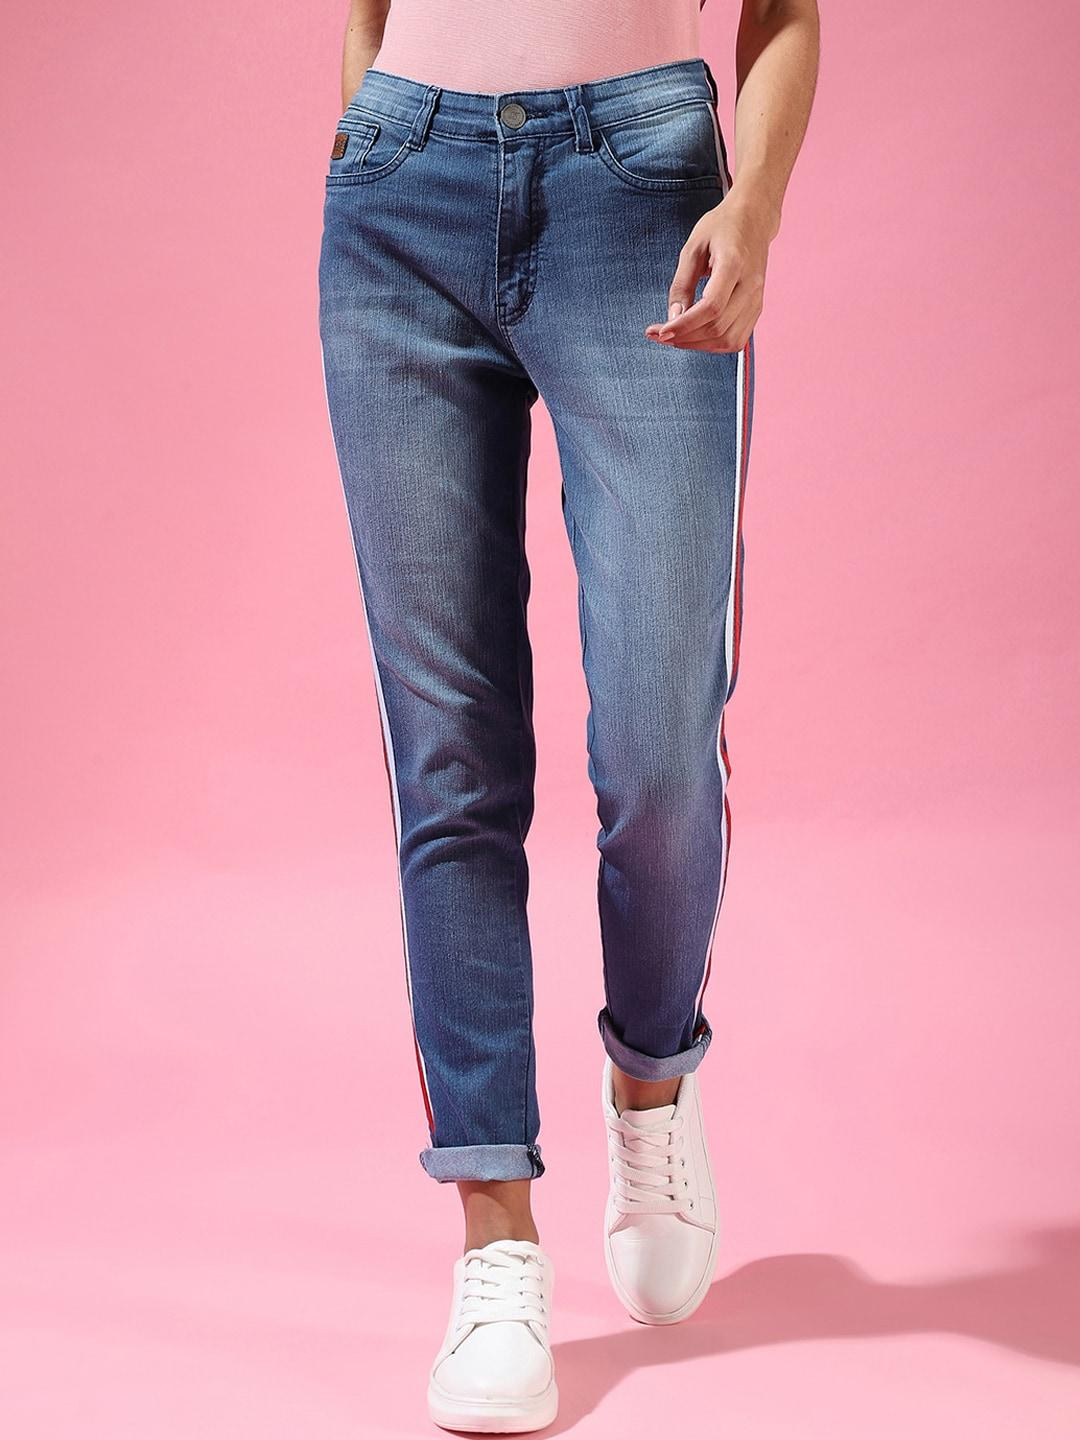

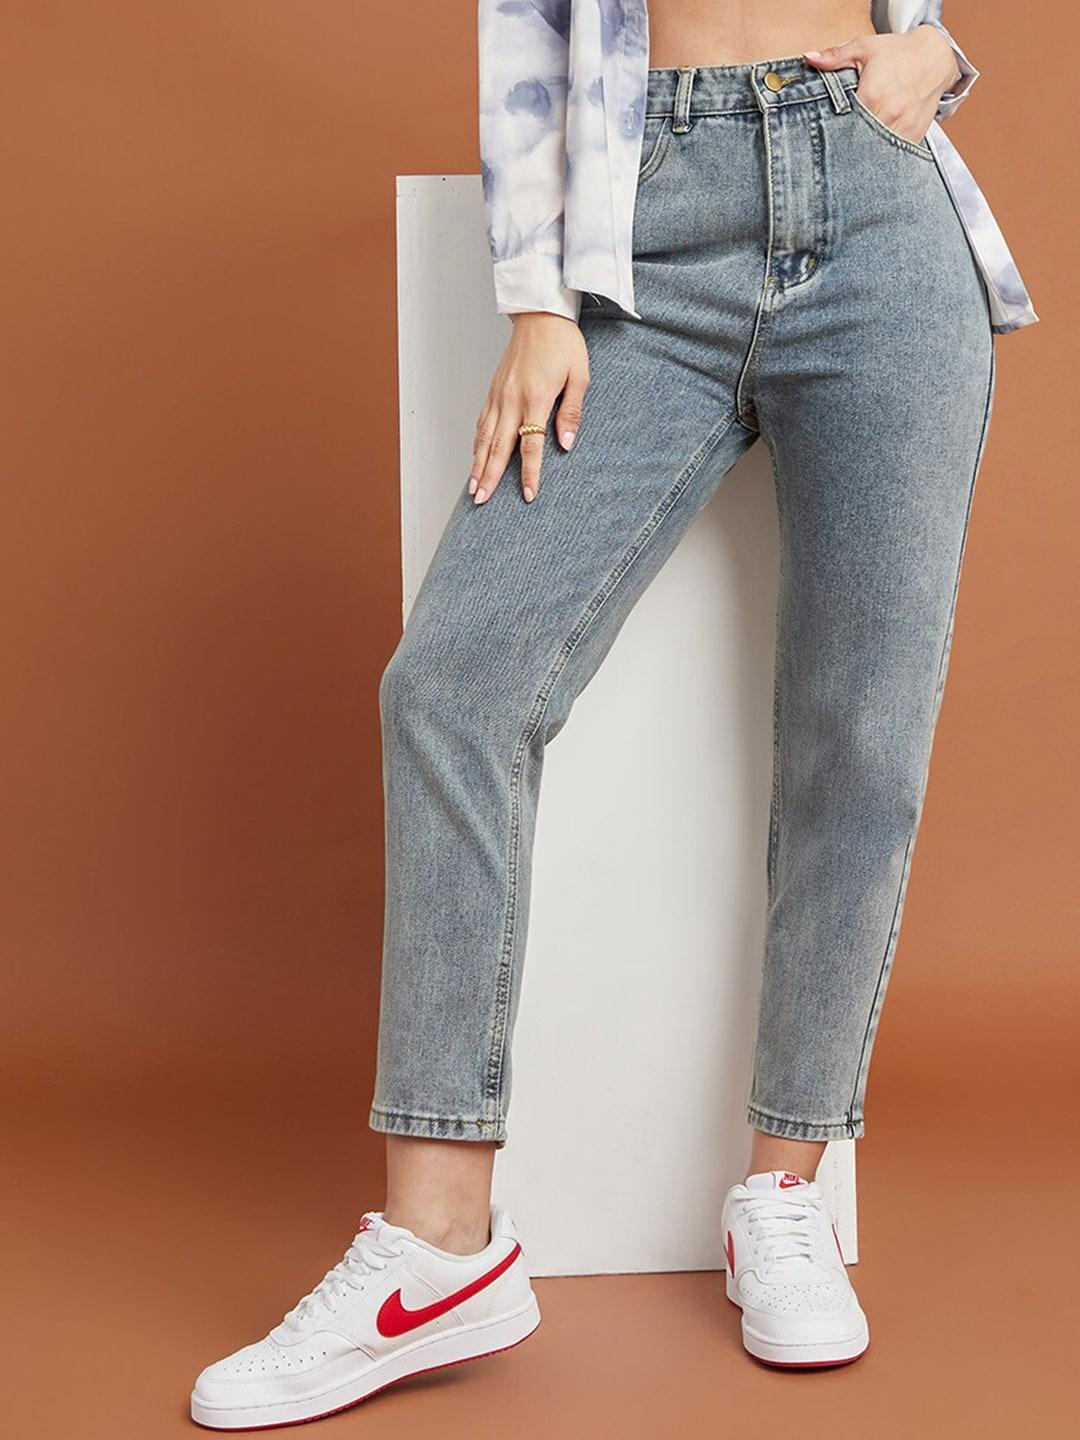

In [ ]:
run_vector_db_search(
    LanceDBSearchQuery(
        database='/kaggle/working/lancedb',
        table_name='myntra',
        query=Path('/content/uploaded_image.png'),  # replace with your input image
        limit=5,
        min_rating=4.0,
        max_budget=2000.0,
        output_path=Path('/kaggle/working/output')
    )
)

In [ ]:
!pip install streamlit -q


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 58.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 86.0 MB/s eta 0:00:00


In [ ]:
!pip install streamlit pyngrok -q


In [ ]:
#import zipfile

#zip_path = "myntra-fashion-product-dataset.zip"
#with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#    zip_ref.extractall("/content/myntra_dataset")


In [ ]:
# app.py
%%writefile app.py
import streamlit as st
from pathlib import Path
from PIL import Image as PILImage
import shutil
import lancedb
import pyarrow as pa
from pydantic import BaseModel
from lancedb.pydantic import LanceModel, Vector
from lancedb.embeddings import EmbeddingFunctionRegistry

# -------------------------
# 1️⃣ Embed model & LanceDB table setup
# -------------------------
def select_embeddings_model(model_name: str = 'open-clip'):
    registry = EmbeddingFunctionRegistry.get_instance()
    model = registry.get(model_name).create()
    return model

model = select_embeddings_model()

class Myntra(LanceModel):
    vector: Vector(model.ndims()) = model.VectorField()
    file_path: str = model.SourceField()
    price: float
    rating: float

# -------------------------
# 2️⃣ Display results helper
# -------------------------
def display_results(df, output_dir, label="Top Results"):
    st.write(f"### {label} — {len(df)} found")

    if output_dir.exists():
        shutil.rmtree(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)

    cols = st.columns(5)
    for idx, item in df.iterrows():
        img = PILImage.open(item.file_path)
        img_path = output_dir / f"{label}_{idx}_p{item.price}_r{item.rating}.jpg"
        img.save(img_path, 'JPEG')
        col = cols[idx % 5]
        with col:
            st.image(img_path, use_container_width=True)
            st.caption(f"₹{item.price} | ⭐{item.rating}")

# -------------------------
# 3️⃣ Search Query Class (added budget)
# -------------------------
class LanceDBSearchQuery(BaseModel):
    database: str
    table_name: str
    query: Path
    limit: int
    output_path: Path
    min_rating: float
    max_budget: float   # ⬅ Added budget filter

# -------------------------
# 4️⃣ Run vector search (budget + rating)
# -------------------------
def run_vector_db_search(query: LanceDBSearchQuery):
    db = lancedb.connect(query.database)
    table = db.open_table(query.table_name)

    search_img = PILImage.open(str(query.query))

    # Apply BOTH filters: budget and rating
    filtered_results = (
        table.search(search_img)
        .where(f"price <= {query.max_budget} AND rating >= {query.min_rating}")
        .limit(query.limit)
        .to_pandas()
    )

    display_results(filtered_results, query.output_path / "filtered_results")

# -------------------------
# 5️⃣ Streamlit UI
# -------------------------
st.set_page_config(page_title="🛍 Myntra Fashion Image Search", layout="wide")
st.title("🛍 Myntra Fashion Image Search")
st.markdown("Upload a product image and find similar products instantly!")

uploaded_file = st.file_uploader("Upload a product image", type=["png", "jpg", "jpeg"])
limit = st.number_input("Number of similar results", min_value=1, max_value=20, value=5)
min_rating = st.slider("Minimum Rating", min_value=0.0, max_value=5.0, value=4.0, step=0.1)
max_budget = st.number_input("💰 Max Budget (₹)", min_value=100.0, value=2000.0, step=100.0)  # ⬅ New input

if uploaded_file is not None:
    upload_path = Path("uploaded_image.png")
    with open(upload_path, "wb") as f:
        f.write(uploaded_file.getbuffer())
    st.image(upload_path, caption="Uploaded Image", use_container_width=True)

    # Run search
    output_dir = Path("output")
    query = LanceDBSearchQuery(
        database='/kaggle/working/lancedb',  # Update path if different
        table_name='myntra',
        query=upload_path,
        limit=limit,
        min_rating=min_rating,
        max_budget=max_budget,  # ⬅ Pass budget
        output_path=output_dir
    )
    run_vector_db_search(query)

Overwriting app.py


In [ ]:
!ngrok authtoken 2j1SYpPoxerIyjKRUuIne32yZDx_6DvnLWvUH2hjY2J33rmfc


Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
!pkill ngrok


In [ ]:
from pyngrok import ngrok
public_url = ngrok.connect(8501)
print("Streamlit URL:", public_url)
!streamlit run app.py --server.port 8501 &> /dev/null &


Streamlit URL: NgrokTunnel: "https://59e44a82a8de.ngrok-free.app" -> "http://localhost:8501"


In [ ]:
import torch
torch.save(model, "myntra1_model.pth")

In [ ]:
#from google.colab import files
#files.download("myntra1_model.pth")